<a href="https://colab.research.google.com/github/zhangou888/NN/blob/main/Full%20code_80_10_10_customized_NN_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Full Code with 80/10/10 Custom Split for Neural Network using PyTorch

## Summary of Key Changes:
- Custom 80/10/10 split: Replaces the built-in test set with split from full dataset
- random_split : used	Ensures samples are randomized and balanced
- Test Evaluation:	Now runs on new held-out 10% test split

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [8]:
# Step 1: Set device - use GPU if available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [9]:
# Step 2: Define a simple CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # 1 input channel (grayscale), 16 output channels
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # 16 input channels, 32 output channels
        self.pool = nn.MaxPool2d(2, 2)                            # 2x2 max pooling
        self.fc1 = nn.Linear(32 * 7 * 7, 128)                     # Fully connected layer
        self.fc2 = nn.Linear(128, 10)                             # Output layer for 10 classes (digits 0-9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)  # Flatten the tensor for the fully connected layers
        x = F.relu(self.fc1(x))
        return self.fc2(x)          # No softmax needed; CrossEntropyLoss handles it

In [10]:
# Step 3: Load and transform data
transform = transforms.ToTensor()  # Convert images to tensor format

# Download full MNIST training set (60,000 samples)
full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [5]:
# Step 4: Create custom 80/10/10 split for train/val/test
train_size = int(0.8 * len(full_dataset))       # 48,000 samples for training
val_size = int(0.1 * len(full_dataset))         # 6,000 samples for validation
test_size = len(full_dataset) - train_size - val_size  # Remaining 6,000 samples for testing

# Randomly split the dataset
train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

In [11]:
# Step 5: Create data loaders for batching
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1000)
test_loader = DataLoader(test_data, batch_size=1000)

In [12]:
# Step 6: Initialize model, loss function, optimizer
model = CNN().to(device)                              # Move model to GPU/CPU
tcriterion = nn.CrossEntropyLoss()                    # Suitable for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001


In [18]:
# Step 7: Training loop
epochs = 5
for epoch in range(epochs):
    model.train()                                  # Set model to training mode
    total_train_loss = 0                           # Track total loss for the epoch

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()                      # Step 1: Clear previous gradients
        outputs = model(images)                    # Step 2: Forward pass
        loss = tcriterion(outputs, labels)         # Step 3: Compute loss
        loss.backward()                            # Step 4: Backward pass (calculate gradients)
        optimizer.step()                           # Step 5: Update weights

        total_train_loss += loss.item()            # Accumulate batch loss

    # Step 8: Validation step
    model.eval()                                   # Set model to evaluation mode
    total_val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():                          # Disable gradient tracking
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = tcriterion(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/5, Train Loss: 51.0098, Val Loss: 0.3526, Val Acc: 98.28%
Epoch 2/5, Train Loss: 36.2400, Val Loss: 0.2910, Val Acc: 98.52%
Epoch 3/5, Train Loss: 26.2471, Val Loss: 0.2072, Val Acc: 98.87%
Epoch 4/5, Train Loss: 20.3783, Val Loss: 0.2292, Val Acc: 98.88%
Epoch 5/5, Train Loss: 16.6429, Val Loss: 0.2938, Val Acc: 98.65%


In [19]:
# Step 9: Final test evaluation
model.eval()
correct = 0
total = 0
all_preds = []
all_images = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_images.extend(images.cpu().numpy())

print(f"Test Accuracy on held-out test set: {100 * correct / total:.2f}%")

Test Accuracy on held-out test set: 98.57%


In [20]:
 # Step 10: Save the trained model
torch.save(model.state_dict(), "mnist_cnn_80_10_10.pth")
print("Model saved as mnist_cnn_80_10_10.pth")

Model saved as mnist_cnn_80_10_10.pth


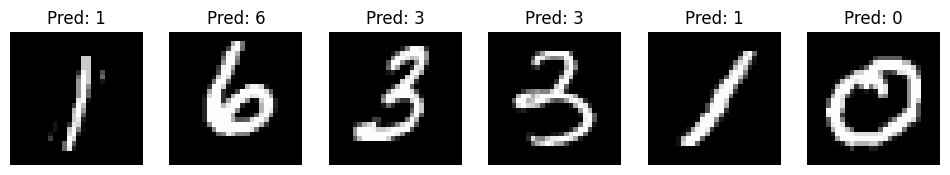

In [21]:
# Step 11: Show sample predictions
def show_predictions(images, preds, n=6):
    plt.figure(figsize=(12, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title(f"Pred: {preds[i]}")
        plt.axis("off")
    plt.show()

show_predictions(all_images, all_preds)